#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
import numpy as np

def loss(X, y, w: np.ndarray, w0: float, gamma=1., beta=1.) -> float:
    """
    Вычисляет Elastic Net Loss.
    X: матрица объектов (N x K)
    y: вектор меток (N,)
    w: вектор весов (K,)
    w0: смещение
    gamma: коэффициент L1
    beta: коэффициент L2
    """
    N = len(y)
    # Логистическая потеря: средняя по объектам
    logits = np.dot(X, w) + w0  # w^T x + w0
    log_loss = np.mean(np.log(1 + np.exp(-y * logits)))
    # Регуляризация
    l1_reg = gamma * np.sum(np.abs(w))
    l2_reg = beta * np.sum(w ** 2)
    return log_loss + l1_reg + l2_reg

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: np.ndarray, w0: float, gamma=1., beta=1.) -> tuple[np.ndarray, float]:
    """
    Вычисляет градиенты по w и w0.
    Возвращает: (grad_w, grad_w0)
    """
    N = len(y)
    logits = np.dot(X, w) + w0
    exp_term = np.exp(y * logits)
    denom = 1 + exp_term  # Общий знаменатель

    # Градиент по w
    # Первая часть: - (1/N) * X^T * (y / denom)
    grad_log_w = - (1/N) * np.dot(X.T, y / denom)
    # Регуляризация: γ * sign(w) + 2β w
    grad_reg_w = gamma * np.sign(w) + 2 * beta * w
    grad_w = grad_log_w + grad_reg_w

    # Градиент по w0
    grad_w0 = - (1/N) * np.sum(y / denom)

    return grad_w, grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []  # Для графика потерь

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.w = np.random.normal(size=X.shape[1])  # Инициализация w
        self.w0 = np.random.normal()  # Инициализация w0

        prev_loss = float('inf')
        for _ in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)

            if abs(current_loss - prev_loss) < self.tolerance:
                break  # Сходимость
            prev_loss = current_loss

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.where(probs >= 0.5, 1, -1)  # Предполагаем y в {-1, 1}

    def predict_proba(self, X):
        logits = np.dot(X, self.w) + self.w0
        return 1 / (1 + np.exp(-logits))  # Сигмоида для вероятностей класса 1

In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [8]:
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y):
    # Сетка для фона
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Предсказания на сетке
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Рисуем
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.title('Decision Boundary')
    plt.show()

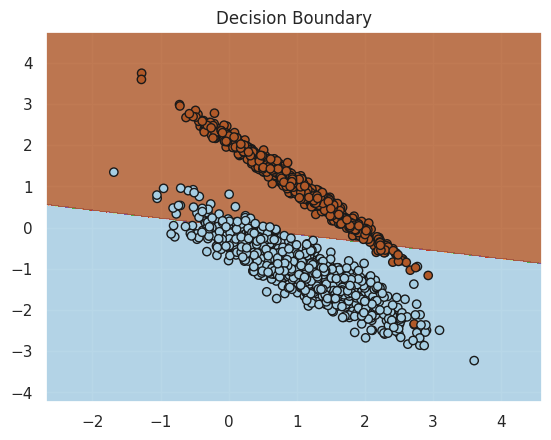

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [10]:
def plot_loss_history(model):
    plt.plot(model.loss_history)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.show()

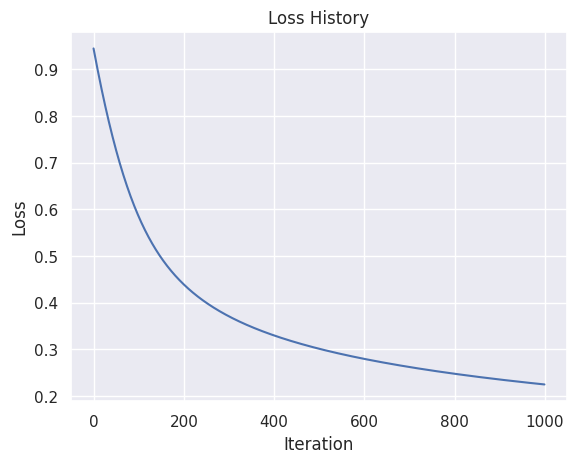

In [11]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

# Разделим данные (80/20 для теста)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Примеры экспериментов
kernels = ['linear', 'rbf', 'poly']
Cs = [0.1, 1, 10]

for kernel in kernels:
    for C in Cs:
        svc = SVC(kernel=kernel, C=C, probability=True)  # probability для ROC
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        y_proba = svc.predict_proba(X_test)[:, 1]  # Для ROC

        print(f"Kernel: {kernel}, C: {C}")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred):.4f}")
        print(f"Recall: {recall_score(y_test, y_pred):.4f}")
        print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
        print(f"F1-Score: {f1_score(y_test, y_pred):.4f}\n")

Kernel: linear, C: 0.1
Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9998
F1-Score: 0.9971

Kernel: linear, C: 1
Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9994
F1-Score: 0.9971

Kernel: linear, C: 10
Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9988
F1-Score: 0.9971

Kernel: rbf, C: 0.1
Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 1.0000
F1-Score: 0.9971

Kernel: rbf, C: 1
Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9998
F1-Score: 0.9971

Kernel: rbf, C: 10
Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9966
F1-Score: 0.9971

Kernel: poly, C: 0.1
Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9963
F1-Score: 0.9971

Kernel: poly, C: 1
Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9977
F1-Score: 0.9971

Kernel: poly, C: 10
Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
AUC-ROC: 0.9985
F1-Score: 0.9971



#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [13]:
class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.w = np.random.normal(size=X.shape[1])
        self.w0 = np.random.normal()

        prev_loss = float('inf')
        for _ in range(self.max_iter):
            logits = np.dot(X, self.w) + self.w0
            errors = 1 - y * logits
            hinge = np.maximum(0, errors)

            # Loss
            current_loss = np.mean(hinge) + self.beta * np.sum(self.w ** 2)
            self.loss_history.append(current_loss)

            if abs(current_loss - prev_loss) < self.tolerance:
                break
            prev_loss = current_loss

            # Градиент
            mask = errors > 0  # Где ошибка >0
            grad_w = -np.dot(X.T, y * mask) / len(y) + 2 * self.beta * self.w
            grad_w0 = -np.sum(y * mask) / len(y)

            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

    def predict(self, X):
        logits = np.dot(X, self.w) + self.w0
        return np.sign(logits)

    def predict_proba(self, X):  # Приближённо, через расстояние к гиперплоскости
        logits = np.dot(X, self.w) + self.w0
        return 1 / (1 + np.exp(-logits))  # Не строго, но для метрик

# Обучение и метрики (аналогично SVC)
model_hinge = HingeLossClassifier()
model_hinge.fit(X_train, y_train)
y_pred = model_hinge.predict(X_test)

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [14]:
from typing import Tuple, List
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.datasets import make_classification

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)  # Для классов 0,1 (adapt if -1,1)

    def predict_proba(self, X):
        dists = cdist(X, self.X_train, metric=self.metric)
        nearest_idx = np.argsort(dists, axis=1)[:, :self.n_neighbors]
        nearest_labels = self.y_train[nearest_idx]
        unique_classes = np.unique(self.y_train)
        probs = np.zeros((len(X), len(unique_classes)))
        for i, cls in enumerate(unique_classes):
            probs[:, i] = np.mean(nearest_labels == cls, axis=1)
        return probs

# Тест на данных
X, y = make_classification(n_samples=1800, n_features=2, n_classes=2, n_informative=2, n_redundant=0, random_state=42)
y = np.where(y == 0, 0, 1)  # Classes 0/1 for proba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and predict
knn = KNNClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 0.9417
Precision: 0.9521
Recall: 0.9244
AUC-ROC: 0.9724
F1-Score: 0.9381


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [15]:
import pandas as pd
import numpy as np  # Для .values

# Загружаем разделённые CSV
train_df = pd.read_csv('fashion-mnist_train.csv')
test_df = pd.read_csv('fashion-mnist_test.csv')

# Объединяем в один DataFrame
full_df = pd.concat([train_df, test_df], ignore_index=True)  # ignore_index — сброс индексов

# Извлекаем фичи (X) и метки (y)
X = full_df.drop('label', axis=1).values
y = full_df['label'].values

# Первые 50k — train, остаток (20k) — test
X_train, X_test = X[:50000], X[50000:]
y_train, y_test = y[:50000], y[50000:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (50000, 784), Test shape: (20000, 784)


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

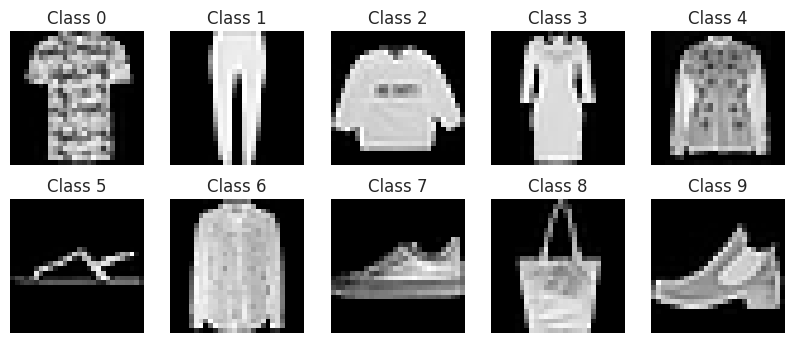

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    idx = np.where(y == i)[0][0]  # Первый представитель класса i
    img = X[idx].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Class {i}')
    ax.axis('off')
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# MinMax
scaler_minmax = MinMaxScaler()
X_train_mm = scaler_minmax.fit_transform(X_train)
X_test_mm = scaler_minmax.transform(X_test)

# Standard
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [18]:
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.utils import resample

# PCA
print("Applying PCA for KNN...")
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_mm)
X_test_pca = pca.transform(X_test_mm)

# Subsample 5000 для KNN (на PCA)
X_train_sub_knn, y_train_sub_knn = resample(X_train_pca, y_train, n_samples=5000, stratify=y_train, random_state=42)

# Subsample 5000 для LogReg (без PCA)
X_train_sub_log, y_train_sub_log = resample(X_train_mm, y_train, n_samples=5000, stratify=y_train, random_state=42)

# KNN: RandomizedSearchCV + fit on sub_knn
print("Starting KNN RandomizedSearchCV on subsample...")
start_time = time.time()
knn_params = {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance'], 'metric': ['euclidean']}
# 'n_neighbors': [3, 5, 10] - 3 и 5 для локальный паттернов, 10 для более сглаженных решений.
# 'weights': ['uniform', 'distance'] - uniform - все соседи равны, distance - ближайшие соседы имеют больший вес
# 'metric': ['euclidean'] - только евклидово расстояние
knn_rand = RandomizedSearchCV(KNeighborsClassifier(), knn_params, n_iter=5, cv=3, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)
knn_rand.fit(X_train_sub_knn, y_train_sub_knn)
print(f"KNN Search completed in {time.time() - start_time:.2f} seconds")
print("Best KNN params:", knn_rand.best_params_)

# Predict KNN
y_pred_knn = knn_rand.best_estimator_.predict(X_test_pca)
print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")

# LogReg: RandomizedSearchCV
print("Starting LogReg RandomizedSearchCV on subsample...")
start_time = time.time()
log_params = {'C': [0.01, 0.1, 1], 'penalty': ['l1', 'l2']}
# 'C': [0.01, 0.1, 1] - сильная, умеренная и слабая регуляризация
# 'penalty': ['l1', 'l2'] - l1 создаёт разреженные модели, l2 уменьшает веса равномерно
log_rand = RandomizedSearchCV(LogisticRegression(max_iter=1000, solver='saga', tol=1e-3),
                              log_params, n_iter=5, cv=3, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)
# n_iter=5 - компромисс между качеством и временем, cv=3 - 3-fold кросс-валидация, scoring='accuracy' - метрика для сравнения моделей, n_jobs=-1 - используем все ядра процессора
log_rand.fit(X_train_sub_log, y_train_sub_log)
print(f"LogReg Search completed in {time.time() - start_time:.2f} seconds")
print("Best LogReg params:", log_rand.best_params_)

# Predict LogReg
y_pred_log = log_rand.best_estimator_.predict(X_test_mm)
print(f"LogReg Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")

# Сравнение метрик (среднее по классам)
print("Calculating metrics...")
for model_name, y_pred in [('KNN', y_pred_knn), ('LogReg', y_pred_log)]:
    print(f"{model_name}: Acc {accuracy_score(y_test, y_pred):.4f}, "
          f"Prec {precision_score(y_test, y_pred, average='macro'):.4f}, "
          f"Rec {recall_score(y_test, y_pred, average='macro'):.4f}, "
          f"F1 {f1_score(y_test, y_pred, average='macro'):.4f}")

Applying PCA for KNN...
Starting KNN RandomizedSearchCV on subsample...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
KNN Search completed in 3.23 seconds
Best KNN params: {'weights': 'distance', 'n_neighbors': 10, 'metric': 'euclidean'}
KNN Accuracy: 0.8176
Starting LogReg RandomizedSearchCV on subsample...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
LogReg Search completed in 725.02 seconds
Best LogReg params: {'penalty': 'l2', 'C': 1}
LogReg Accuracy: 0.8249
Calculating metrics...
KNN: Acc 0.8176, Prec 0.8187, Rec 0.8173, F1 0.8171
LogReg: Acc 0.8249, Prec 0.8249, Rec 0.8248, F1 0.8247


## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.